In [4]:
!rm -rf /kaggle/working/

rm: cannot remove '/kaggle/working/': Device or resource busy


In [5]:
!git clone --branch Unet --single-branch https://github.com/nWoWolfpac/FinalADCV

Cloning into 'FinalADCV'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 147 (delta 50), reused 127 (delta 30), pack-reused 0 (from 0)
Receiving objects: 100% (147/147), 3.27 MiB | 33.77 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [14]:
import sys
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from torch.utils.data import DataLoader
project_root = Path('/kaggle/working/FinalADCV')
sys.path.insert(0, str(project_root))
sys.path.append('/kaggle/working/FinalADCV/src')


In [3]:
!pip install -r /kaggle/working/FinalADCV/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 11.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.1 MB/s e

# 1. DFC 2020 dataset preview

## 1.1 Load dfc2020 dataset

In [10]:
from config import (
    DATASET_DFC2020, 
    STAGE2, 
    NUM_CLASSES, 
    CLASS_NAMES,
    SENTINEL1_MEAN,
    SENTINEL1_STD,
    SENTINEL2_MEAN,
    SENTINEL2_STD
)

In [11]:
from data.dataset_utils import create_dfc2020_loaders

#from config
batch_size = 16
input_size = 64
num_workers = 4

train_dataset, val_dataset, test_dataset = create_dfc2020_loaders(batch_size, input_size, num_workers)



Loading dataset shards:   0%|          | 0/42 [00:00<?, ?it/s]

DFC2020 splits sizes: train=41535, val=4617, test=8874


## 1.2 Save dataset

In [ ]:
import torch
import numpy as np
import matplotlib as plt 
from torch.utils.data import DataLoader

def extract_and_save(loader: DataLoader, save_path: str):
    all_images = []
    all_masks = []
    for batch in loader:
        images = batch['image']
        masks = batch['mask']
        all_images.extend(images)
        all_masks.extend(masks)
    torch.save(all_images, save_path + '_images.pt')
    torch.save(all_masks, save_path + '_masks.pt')
    print(f"Saved {len(all_images)} images and {len(all_masks)} masks to {save_path}")
def load_dataset_from_data(load_path):
    data = torch.load(load_path, weights_only=False)
    
    class SimpleDataset(torch.utils.data.Dataset):
        def __init__(self, images, masks):
            self.images = images
            self.masks = masks
        def __len__(self):
            return len(self.images)
        def __getitem__(self, idx):
            return {
                'image': self.images[idx],
                'mask': self.masks[idx]
            }
    
    return SimpleDataset(data['images'], data['masks'])

In [ ]:
extract_and_save(train_dataset, '/kaggle/working/train_dataset_data.pt')
extract_and_save(val_dataset, '/kaggle/working/val_dataset_data.pt')
extract_and_save(test_dataset, '/kaggle/working/test_dataset_data.pt')

## 1.3 Dataset statics 

In [16]:
def analyze_class_distribution(dataloader, split_name="Train", max_samples=1000):
    """
    Analyze class distribution in the dataset
    """
    print(f"\nAnalyzing {split_name} set class distribution...")
    class_counts = Counter()
    total_pixels = 0
    samples_analyzed = 0
    
    for batch in dataloader:
        masks = batch['mask'].numpy()
        for mask in masks:
            unique, counts = np.unique(mask, return_counts=True)
            for cls, count in zip(unique, counts):
                class_counts[int(cls)] += count
                total_pixels += count
        
        samples_analyzed += masks.shape[0]
        if samples_analyzed >= max_samples:
            break
    
    return class_counts, total_pixels, samples_analyzed

# Analyze train set
train_class_counts, train_total_pixels, train_samples = analyze_class_distribution(
    train_dataset, "Train", max_samples=1000
)

print("\n📈 CLASS DISTRIBUTION (Train Set - First 1000 samples)")
print("="*60)
print(f"Total pixels analyzed: {train_total_pixels:,}")
print(f"Samples analyzed: {train_samples}\n")

for cls in sorted(train_class_counts.keys()):
    count = train_class_counts[cls]
    percentage = (count / train_total_pixels) * 100
    print(f"Class {cls}: {count:>10,} pixels ({percentage:>6.2f}%)")
print("="*60)



Analyzing Train set class distribution...

📈 CLASS DISTRIBUTION (Train Set - First 1000 samples)
Total pixels analyzed: 4,128,768
Samples analyzed: 1008

Class 0:    777,581 pixels ( 18.83%)
Class 1:     30,282 pixels (  0.73%)
Class 2:    566,136 pixels ( 13.71%)
Class 3:     65,294 pixels (  1.58%)
Class 4:    749,802 pixels ( 18.16%)
Class 5:    465,317 pixels ( 11.27%)
Class 6:      3,098 pixels (  0.08%)
Class 7:    829,314 pixels ( 20.09%)
Class 255:    641,944 pixels ( 15.55%)


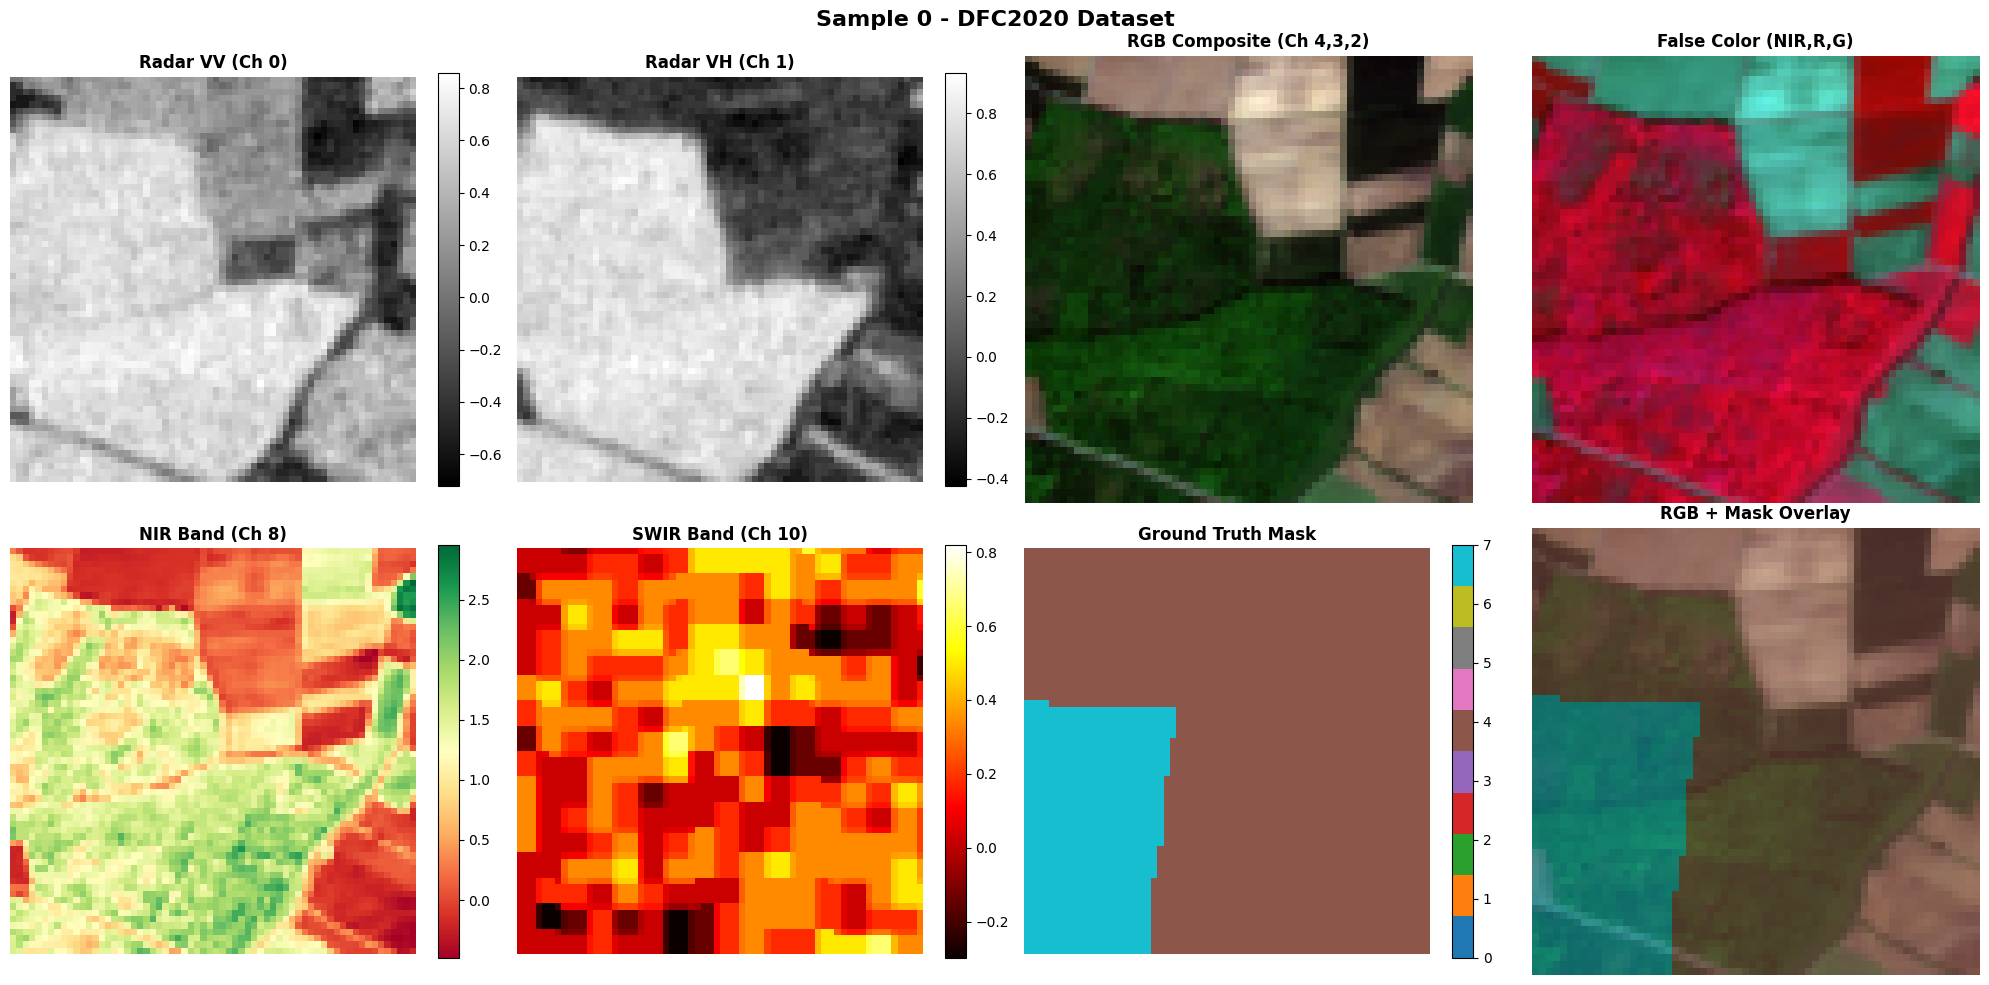


📊 Sample 0 Statistics:
  Image shape: (12, 64, 64)
  Mask shape:  (64, 64)
  Image range: [-0.978, 2.957]
  Mask values: [  4 255]
  Classes in mask: 2 classes


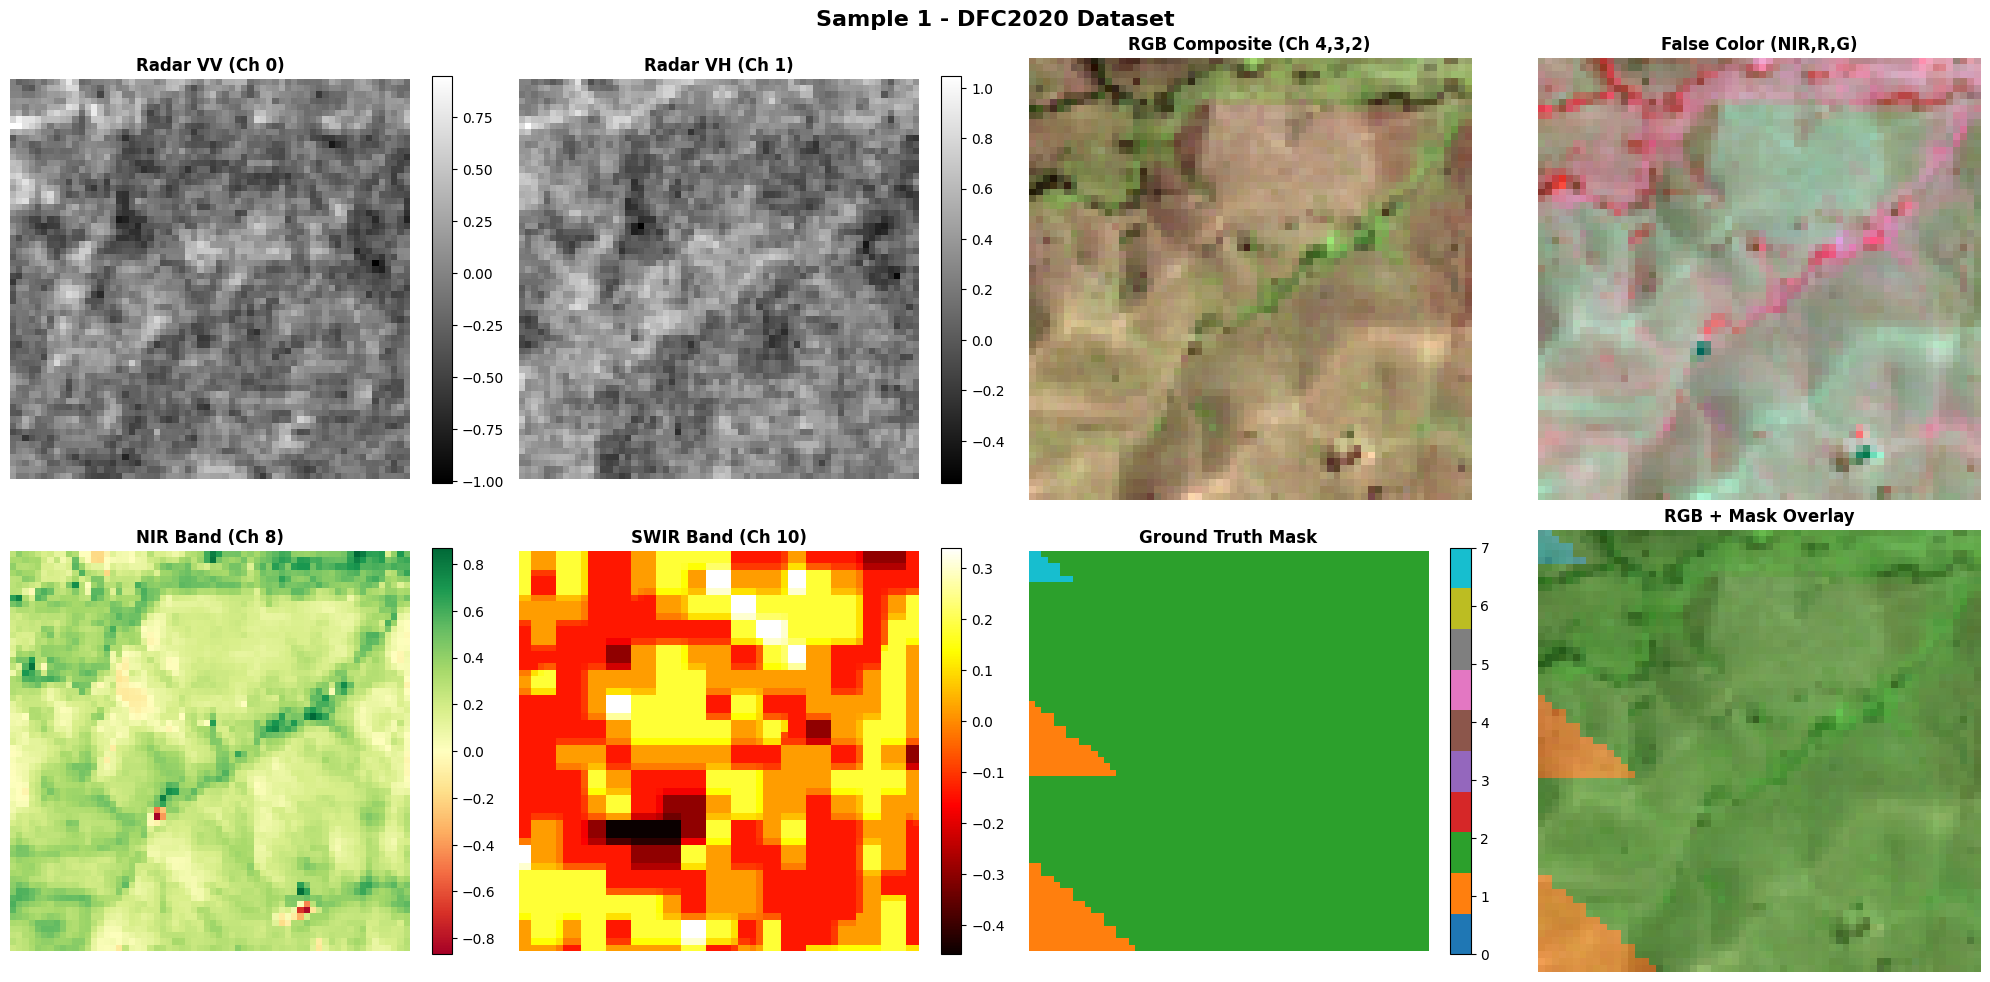


📊 Sample 1 Statistics:
  Image shape: (12, 64, 64)
  Mask shape:  (64, 64)
  Image range: [-1.007, 1.833]
  Mask values: [  1   2 255]
  Classes in mask: 3 classes


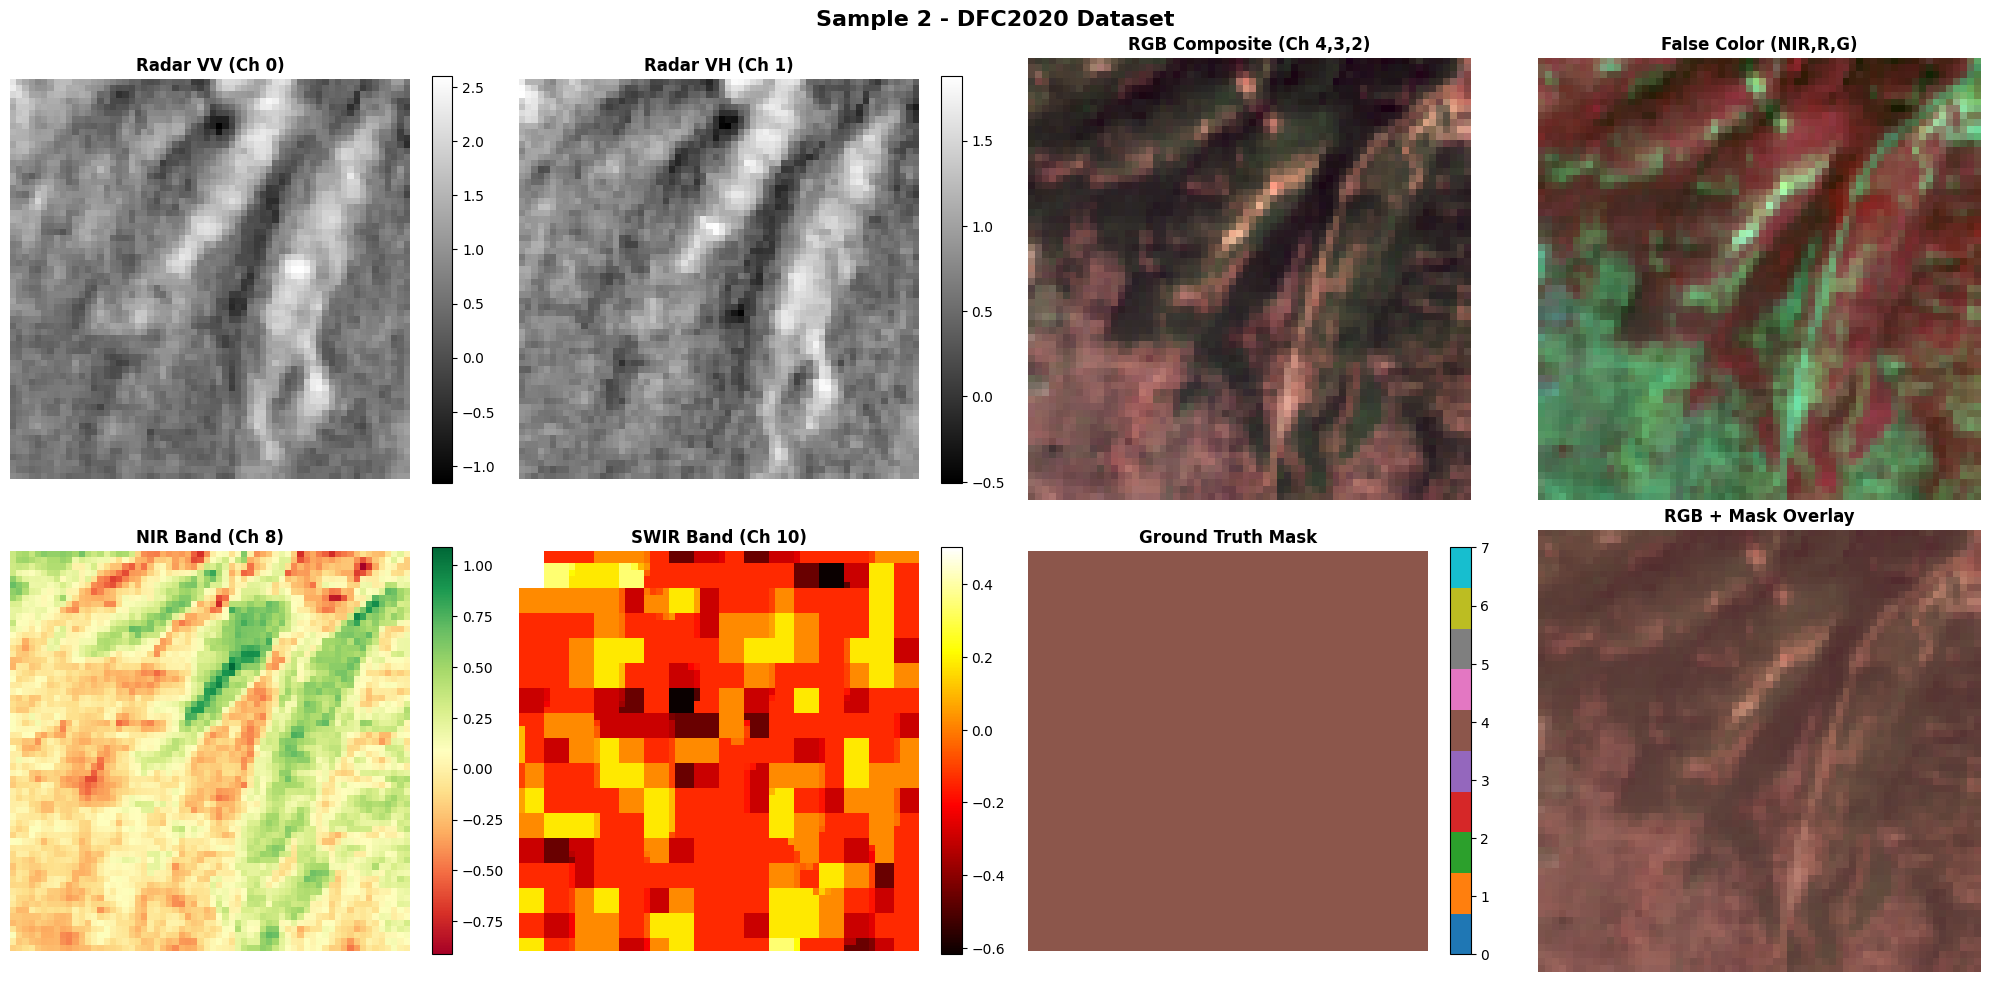


📊 Sample 2 Statistics:
  Image shape: (12, 64, 64)
  Mask shape:  (64, 64)
  Image range: [-1.156, 2.607]
  Mask values: [4]
  Classes in mask: 1 classes


In [21]:
def visualize_sample(image, mask, sample_idx=0):
    """
    Visualize a single sample with multiple channel views
    
    Args:
        image: torch.Tensor of shape (C, H, W) with 12 channels
        mask: torch.Tensor of shape (H, W)
        sample_idx: index of the sample
    """
    image_np = image.cpu().numpy()
    mask_np = mask.cpu().numpy()
    
    # Handle mask shape: squeeze if it has channel dimension (1, H, W) -> (H, W)
    if mask_np.ndim == 3:
        mask_np = mask_np.squeeze(0)
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(f'Sample {sample_idx} - DFC2020 Dataset', fontsize=16, fontweight='bold')
    
    # Plot 1: Radar VV (Channel 0)
    im1 = axes[0, 0].imshow(image_np[0], cmap='gray')
    axes[0, 0].set_title('Radar VV (Ch 0)', fontweight='bold')
    axes[0, 0].axis('off')
    plt.colorbar(im1, ax=axes[0, 0], fraction=0.046)
    
    # Plot 2: Radar VH (Channel 1)
    im2 = axes[0, 1].imshow(image_np[1], cmap='gray')
    axes[0, 1].set_title('Radar VH (Ch 1)', fontweight='bold')
    axes[0, 1].axis('off')
    plt.colorbar(im2, ax=axes[0, 1], fraction=0.046)
    
    # Plot 3: RGB Composite (Channels 4, 3, 2 = Red, Green, Blue)
    # Normalize for visualization
    rgb = np.stack([image_np[4], image_np[3], image_np[2]], axis=-1)
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)
    axes[0, 2].imshow(rgb)
    axes[0, 2].set_title('RGB Composite (Ch 4,3,2)', fontweight='bold')
    axes[0, 2].axis('off')
    
    # Plot 4: False Color (NIR, Red, Green)
    false_color = np.stack([image_np[8], image_np[4], image_np[3]], axis=-1)
    false_color = (false_color - false_color.min()) / (false_color.max() - false_color.min() + 1e-8)
    axes[0, 3].imshow(false_color)
    axes[0, 3].set_title('False Color (NIR,R,G)', fontweight='bold')
    axes[0, 3].axis('off')
    
    # Plot 5: NIR Band (Channel 8)
    im5 = axes[1, 0].imshow(image_np[8], cmap='RdYlGn')
    axes[1, 0].set_title('NIR Band (Ch 8)', fontweight='bold')
    axes[1, 0].axis('off')
    plt.colorbar(im5, ax=axes[1, 0], fraction=0.046)
    
    # Plot 6: SWIR Band (Channel 10)
    im6 = axes[1, 1].imshow(image_np[10], cmap='hot')
    axes[1, 1].set_title('SWIR Band (Ch 10)', fontweight='bold')
    axes[1, 1].axis('off')
    plt.colorbar(im6, ax=axes[1, 1], fraction=0.046)
    
    # Plot 7: Ground Truth Mask
    im7 = axes[1, 2].imshow(mask_np, cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
    axes[1, 2].set_title('Ground Truth Mask', fontweight='bold')
    axes[1, 2].axis('off')
    cbar = plt.colorbar(im7, ax=axes[1, 2], fraction=0.046)
    cbar.set_ticks(range(NUM_CLASSES))
    
    # Plot 8: Mask with overlay on RGB
    axes[1, 3].imshow(rgb)
    im8 = axes[1, 3].imshow(mask_np, cmap='tab10', alpha=0.5, vmin=0, vmax=NUM_CLASSES-1)
    axes[1, 3].set_title('RGB + Mask Overlay', fontweight='bold')
    axes[1, 3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print sample statistics
    print(f"\n📊 Sample {sample_idx} Statistics:")
    print(f"  Image shape: {image_np.shape}")
    print(f"  Mask shape:  {mask_np.shape}")
    print(f"  Image range: [{image_np.min():.3f}, {image_np.max():.3f}]")
    print(f"  Mask values: {np.unique(mask_np)}")
    print(f"  Classes in mask: {len(np.unique(mask_np))} classes")

# Get a batch and visualize first 3 samples
sample_batch = next(iter(train_dataset))
num_samples_to_show = min(3, sample_batch['image'].shape[0])

for i in range(num_samples_to_show):
    visualize_sample(sample_batch['image'][i], sample_batch['mask'][i], sample_idx=i)


### Nhận xét
- Grouth truth đang mất đi quá nhiều thông tin
- Lí do là khi input_size = 96

SO SÁNH MASK GỐC vs MASK ĐÃ RESIZE


Loading dataset shards:   0%|          | 0/42 [00:00<?, ?it/s]


📐 MASK GỐC (từ HuggingFace dataset):
   Shape: (96, 96)
   Số pixels: 9,216
   Classes: [0, 2, 255]

📐 MASK ĐÃ RESIZE (từ train_dataset.pt):
   Shape: (64, 64)
   Số pixels: 4,096
   Classes: [0, 2, 255]

📊 SO SÁNH:
   Kích thước gốc: 96×96
   Kích thước sau resize: 64×64
   Tỷ lệ giữ lại: 44.44%
   ⚠️  Mask đã bị resize!


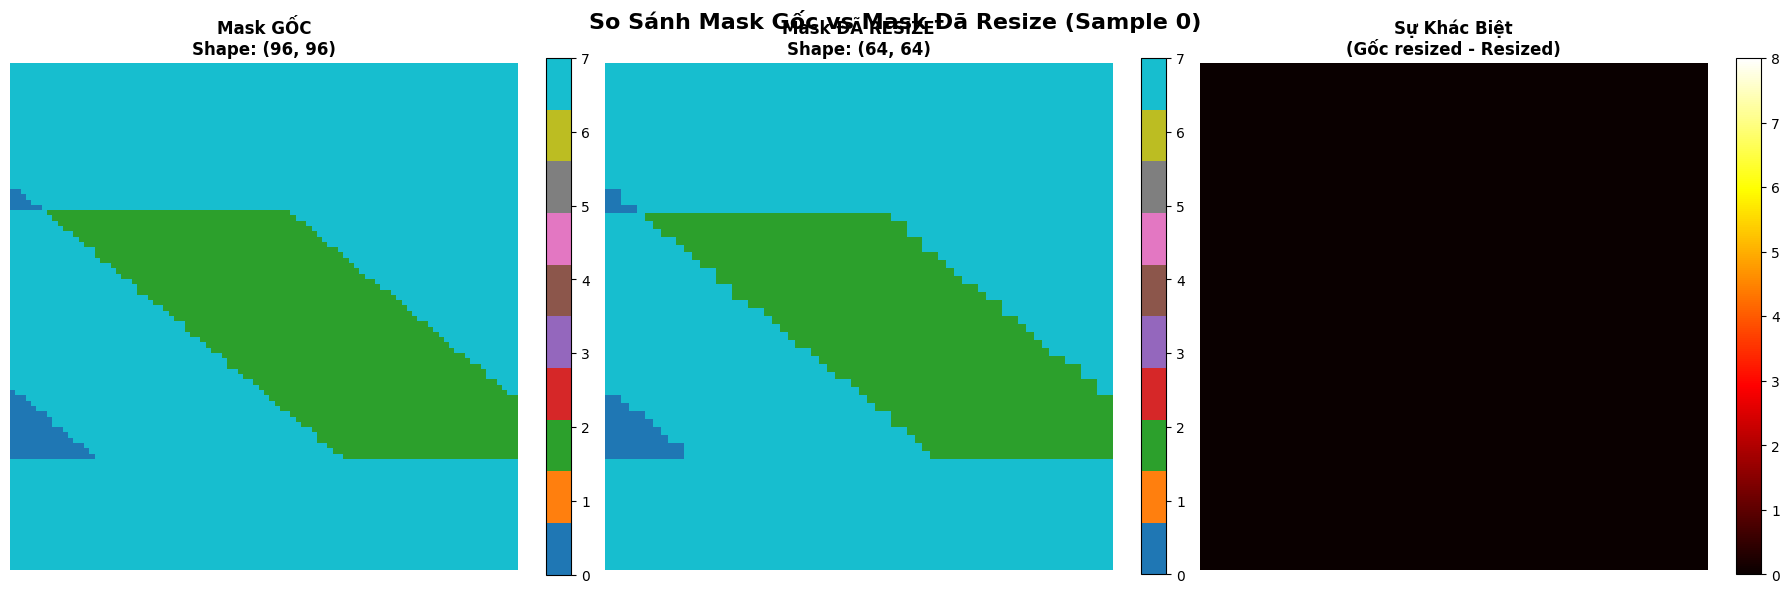


✅ So sánh hoàn tất!

💡 Kết luận:
   ⚠️  Mask đã bị resize!
   → Gốc: (96, 96), Sau resize: (64, 64)


In [25]:
# test thử mask với input_size = 128 và 256
# So sánh GT mask với các input_size khác nhau

# Cell mới: Kiểm tra mask GỐC vs mask đã resize
from datasets import load_dataset
from config import DATASET_DFC2020
import numpy as np
import matplotlib.pyplot as plt

print("="*70)
print("SO SÁNH MASK GỐC vs MASK ĐÃ RESIZE")
print("="*70)

# Load dataset GỐC từ HuggingFace (chưa qua DFC2020Dataset)
ds = load_dataset(DATASET_DFC2020, trust_remote_code=True)
train_split = ds["train"]

# Lấy sample đầu tiên
example_idx = 0
example = train_split[example_idx]

# Mask GỐC (chưa resize)
label_original = np.array(example["label"], dtype=np.int64)
print(f"\n📐 MASK GỐC (từ HuggingFace dataset):")
print(f"   Shape: {label_original.shape}")
print(f"   Số pixels: {label_original.size:,}")
print(f"   Classes: {np.unique(label_original).tolist()}")

# Mask từ train_dataset (đã resize)
sample_from_loaded = train_dataset.dataset[example_idx]
mask_resized = sample_from_loaded["mask"].numpy()
if mask_resized.ndim == 3:
    mask_resized = mask_resized.squeeze(0)

print(f"\n📐 MASK ĐÃ RESIZE (từ train_dataset.pt):")
print(f"   Shape: {mask_resized.shape}")
print(f"   Số pixels: {mask_resized.size:,}")
print(f"   Classes: {np.unique(mask_resized).tolist()}")

# So sánh
print(f"\n📊 SO SÁNH:")
print(f"   Kích thước gốc: {label_original.shape[0]}×{label_original.shape[1]}")
print(f"   Kích thước sau resize: {mask_resized.shape[0]}×{mask_resized.shape[1]}")
if label_original.shape != mask_resized.shape:
    ratio = (mask_resized.size / label_original.size) * 100
    print(f"   Tỷ lệ giữ lại: {ratio:.2f}%")
    print(f"   ⚠️  Mask đã bị resize!")

# Visualize so sánh
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'So Sánh Mask Gốc vs Mask Đã Resize (Sample {example_idx})', 
             fontsize=16, fontweight='bold')

# Mask gốc (có thể cần resize để hiển thị nếu quá lớn)
try:
    if label_original.shape[0] > 512 or label_original.shape[1] > 512:
        # Resize để hiển thị
        from torch.nn.functional import interpolate
        label_display = interpolate(
            torch.from_numpy(label_original).unsqueeze(0).unsqueeze(0).float(),
            size=(512, 512),
            mode='nearest'
        ).squeeze(0).squeeze(0).numpy()
        title_orig = f'Mask GỐC (resized để hiển thị)\nShape gốc: {label_original.shape}'
    else:
        label_display = label_original
        title_orig = f'Mask GỐC\nShape: {label_original.shape}'
    
    im0 = axes[0].imshow(label_display, cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
    axes[0].set_title(title_orig, fontweight='bold')
    axes[0].axis('off')
    plt.colorbar(im0, ax=axes[0], fraction=0.046)
except Exception as e:
    axes[0].text(0.5, 0.5, f'Mask gốc quá lớn\nđể hiển thị\nShape: {label_original.shape}', 
                ha='center', va='center', fontsize=12)
    axes[0].axis('off')

# Mask đã resize
im1 = axes[1].imshow(mask_resized, cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
axes[1].set_title(f'Mask ĐÃ RESIZE\nShape: {mask_resized.shape}', fontweight='bold')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# So sánh side-by-side (nếu cùng kích thước hoặc resize để so sánh)
try:
    if label_original.shape == mask_resized.shape:
        diff = np.abs(label_original.astype(float) - mask_resized.astype(float))
        im2 = axes[2].imshow(diff, cmap='hot', vmin=0, vmax=NUM_CLASSES)
        axes[2].set_title('Sự Khác Biệt\n(Gốc - Resized)', fontweight='bold')
        axes[2].axis('off')
        plt.colorbar(im2, ax=axes[2], fraction=0.046)
    else:
        # Resize mask gốc về cùng kích thước để so sánh
        from torch.nn.functional import interpolate
        label_resized_for_compare = interpolate(
            torch.from_numpy(label_original).unsqueeze(0).unsqueeze(0).float(),
            size=(mask_resized.shape[0], mask_resized.shape[1]),
            mode='nearest'
        ).squeeze(0).squeeze(0).numpy()
        
        diff = np.abs(label_resized_for_compare.astype(float) - mask_resized.astype(float))
        im2 = axes[2].imshow(diff, cmap='hot', vmin=0, vmax=NUM_CLASSES)
        axes[2].set_title(f'Sự Khác Biệt\n(Gốc resized - Resized)', fontweight='bold')
        axes[2].axis('off')
        plt.colorbar(im2, ax=axes[2], fraction=0.046)
except Exception as e:
    axes[2].text(0.5, 0.5, 'Không thể\nso sánh', ha='center', va='center', fontsize=12)
    axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\n✅ So sánh hoàn tất!")
print("\n💡 Kết luận:")
if label_original.shape == mask_resized.shape:
    print("   ✅ Mask gốc và mask đã resize có cùng kích thước")
    print("   → Có thể dataset gốc đã là 96×96!")
else:
    print("   ⚠️  Mask đã bị resize!")
    print(f"   → Gốc: {label_original.shape}, Sau resize: {mask_resized.shape}")


Loading dataset shards:   0%|          | 0/42 [00:00<?, ?it/s]

Mask gốc shape: (96, 96)
Mask gốc classes: [0, 2, 255]


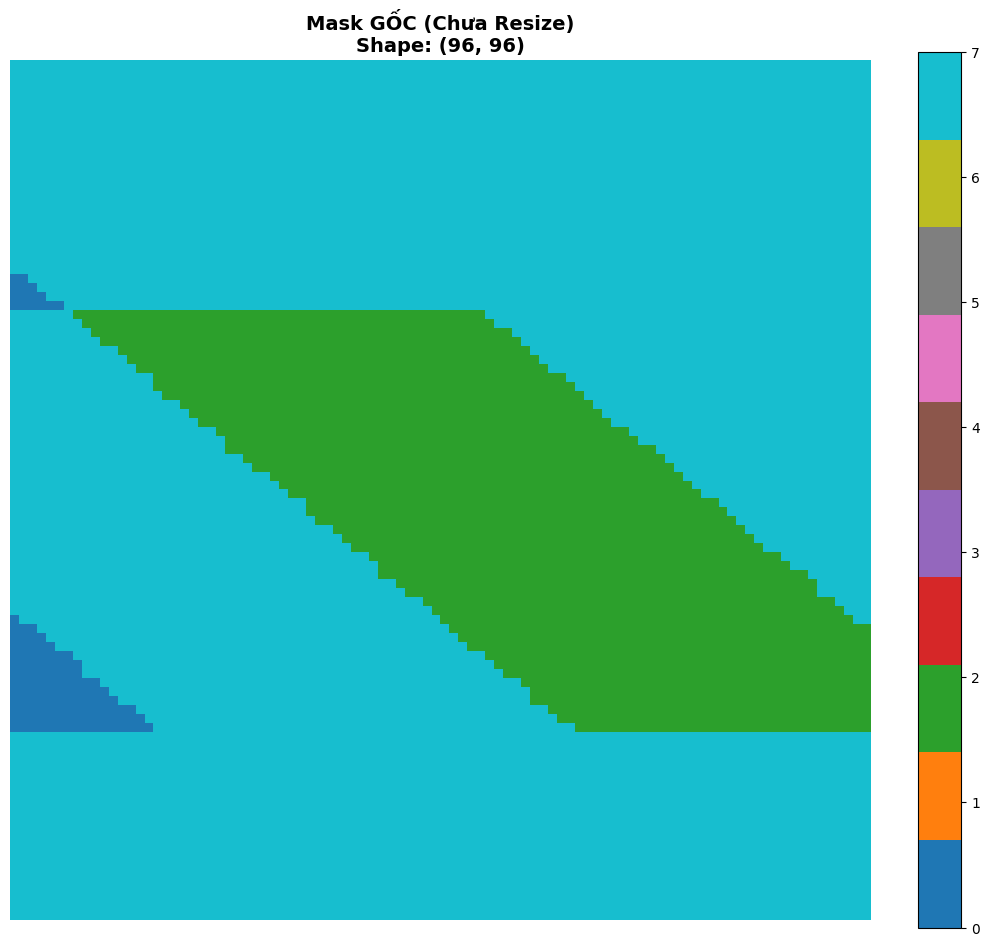

In [24]:
# Visualize mask GỐC trực tiếp từ HuggingFace
from datasets import load_dataset
from config import DATASET_DFC2020
import numpy as np
import matplotlib.pyplot as plt

# Load dataset gốc
ds = load_dataset(DATASET_DFC2020, trust_remote_code=True)
example = ds["train"][0]  # Sample đầu tiên

# Lấy mask GỐC (chưa qua DFC2020Dataset)
label_original = np.array(example["label"], dtype=np.int64)

print(f"Mask gốc shape: {label_original.shape}")
print(f"Mask gốc classes: {np.unique(label_original).tolist()}")

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
im = ax.imshow(label_original, cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
ax.set_title(f'Mask GỐC (Chưa Resize)\nShape: {label_original.shape}', 
             fontsize=14, fontweight='bold')
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)
plt.tight_layout()
plt.show()

# Tranining process

In [ ]:
"""
Script để tính normalization stats (mean và std) từ DFC2020 dataset
"""
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from config import DATASET_DFC2020, STAGE2

# Index các kênh optical được sử dụng
OPTICAL_CHANNELS_10 = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11]  # B02..B08, B8A, B11, B12

def compute_stats(num_samples=5000):
    """
    Tính mean và std từ dataset
    
    Args:
        num_samples: Số samples để tính stats (dùng toàn bộ nếu None)
    """
    print("=" * 70)
    print("TÍNH NORMALIZATION STATS TỪ DFC2020 DATASET")
    print("=" * 70)
    
    # Load dataset
    print("\nLoading dataset...")
    ds = load_dataset(DATASET_DFC2020, trust_remote_code=True)
    train_split = ds["train"]
    
    total_samples = len(train_split)
    if num_samples is None or num_samples > total_samples:
        num_samples = total_samples
    
    print(f"Total samples: {total_samples}")
    print(f"Using samples: {num_samples}")
    
    # Khởi tạo accumulators
    radar_sum = np.zeros(2, dtype=np.float64)
    radar_sq_sum = np.zeros(2, dtype=np.float64)
    optical_sum = np.zeros(10, dtype=np.float64)
    optical_sq_sum = np.zeros(10, dtype=np.float64)
    
    pixel_count = 0
    
    print("\nComputing statistics...")
    for i in tqdm(range(num_samples), desc="Processing"):
        example = train_split[i]
        
        # Load raw data (chưa normalize)
        radar = np.array(example["radar"], dtype=np.float32)  # (2, H, W)
        optical = np.array(example["optical"], dtype=np.float32)  # (13, H, W)
        
        # Chọn 10 kênh optical
        optical = optical[OPTICAL_CHANNELS_10, :, :]  # (10, H, W)
        
        # Tính stats cho radar (2 channels)
        radar_flat = radar.reshape(2, -1)  # (2, H*W)
        radar_sum += radar_flat.sum(axis=1)
        radar_sq_sum += (radar_flat ** 2).sum(axis=1)
        
        # Tính stats cho optical (10 channels)
        optical_flat = optical.reshape(10, -1)  # (10, H*W)
        optical_sum += optical_flat.sum(axis=1)
        optical_sq_sum += (optical_flat ** 2).sum(axis=1)
        
        pixel_count += radar.shape[1] * radar.shape[2]  # H * W
    
    # Tính mean và std
    radar_mean = radar_sum / pixel_count
    radar_std = np.sqrt(radar_sq_sum / pixel_count - radar_mean ** 2)
    
    optical_mean = optical_sum / pixel_count
    optical_std = np.sqrt(optical_sq_sum / pixel_count - optical_mean ** 2)
    
    # Print results
    print("\n" + "=" * 70)
    print("KẾT QUẢ NORMALIZATION STATS")
    print("=" * 70)
    
    print("\n📡 SENTINEL-1 RADAR (2 channels):")
    print(f"  Channel 0 (VV):")
    print(f"    Mean: {radar_mean[0]:.6f}")
    print(f"    Std:  {radar_std[0]:.6f}")
    print(f"  Channel 1 (VH):")
    print(f"    Mean: {radar_mean[1]:.6f}")
    print(f"    Std:  {radar_std[1]:.6f}")
    
    print("\n🛰️  SENTINEL-2 OPTICAL (10 channels):")
    channel_names = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
    for i, name in enumerate(channel_names):
        print(f"  Channel {i} ({name}):")
        print(f"    Mean: {optical_mean[i]:.6f}")
        print(f"    Std:  {optical_std[i]:.6f}")
    
    # Generate code để update config.py
    print("\n" + "=" * 70)
    print("CODE ĐỂ UPDATE config.py")
    print("=" * 70)
    print("\n# Copy đoạn code sau vào config.py:")
    print("\n# Normalization stats computed from DFC2020 dataset")
    print(f"# Computed from {num_samples} samples")
    print(f"SENTINEL1_MEAN = [{radar_mean[0]:.6f}, {radar_mean[1]:.6f}]")
    print(f"SENTINEL1_STD = [{radar_std[0]:.6f}, {radar_std[1]:.6f}]")
    
    print(f"\nSENTINEL2_MEAN = [")
    print(f"    {optical_mean[0]:.6f},  # B02")
    print(f"    {optical_mean[1]:.6f},  # B03")
    print(f"    {optical_mean[2]:.6f},  # B04")
    print(f"    {optical_mean[3]:.6f},  # B05")
    print(f"    {optical_mean[4]:.6f},  # B06")
    print(f"    {optical_mean[5]:.6f},  # B07")
    print(f"    {optical_mean[6]:.6f},  # B08")
    print(f"    {optical_mean[7]:.6f},  # B8A")
    print(f"    {optical_mean[8]:.6f},  # B11")
    print(f"    {optical_mean[9]:.6f},  # B12")
    print(f"]")
    
    print(f"\nSENTINEL2_STD = [")
    print(f"    {optical_std[0]:.6f},  # B02")
    print(f"    {optical_std[1]:.6f},  # B03")
    print(f"    {optical_std[2]:.6f},  # B04")
    print(f"    {optical_std[3]:.6f},  # B05")
    print(f"    {optical_std[4]:.6f},  # B06")
    print(f"    {optical_std[5]:.6f},  # B07")
    print(f"    {optical_std[6]:.6f},  # B08")
    print(f"    {optical_std[7]:.6f},  # B8A")
    print(f"    {optical_std[8]:.6f},  # B11")
    print(f"    {optical_std[9]:.6f},  # B12")
    print(f"]")
    
    print("\n" + "=" * 70)
    print("LƯU Ý:")
    print("=" * 70)
    print("1. SENTINEL2_MEAN và SENTINEL2_STD có 10 giá trị (cho 10 channels được chọn)")
    print("2. Trong dataset_utils.py, chỉ sử dụng OPTICAL_CHANNELS_10")
    print("3. Nếu dataset có 13 channels, cần map đúng index")
    
    return radar_mean, radar_std, optical_mean, optical_std


if __name__ == "__main__":
    # Tính stats từ 5000 samples (có thể tăng nếu muốn chính xác hơn)
    radar_mean, radar_std, optical_mean, optical_std = compute_stats(num_samples=5000)
    
    print("\n✅ Hoàn thành!")



In [ ]:
!python /kaggle/working/FinalADCV/training_unet.py 

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Visualize result and prediction

In [6]:
!python /kaggle/working/FinalADCV/evaluate_unet.py --checkpoint /kaggle/input/pretrained-weight-unet/best_model.pth

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [7]:
!zip -r prediction.zip /kaggle/working/visualizations

  adding: kaggle/working/visualizations/ (stored 0%)
  adding: kaggle/working/visualizations/test_predictions/ (stored 0%)
  adding: kaggle/working/visualizations/test_predictions/sample_8.png (deflated 13%)
  adding: kaggle/working/visualizations/test_predictions/sample_0.png (deflated 12%)
  adding: kaggle/working/visualizations/test_predictions/sample_5.png (deflated 13%)
  adding: kaggle/working/visualizations/test_predictions/sample_7.png (deflated 13%)
  adding: kaggle/working/visualizations/test_predictions/sample_2.png (deflated 13%)
  adding: kaggle/working/visualizations/test_predictions/sample_3.png (deflated 13%)
  adding: kaggle/working/visualizations/test_predictions/sample_6.png (deflated 13%)
  adding: kaggle/working/visualizations/test_predictions/sample_1.png (deflated 13%)
  adding: kaggle/working/visualizations/test_predictions/sample_9.png (deflated 13%)
  adding: kaggle/working/visualizations/test_predictions/sample_4.png (deflated 13%)
